<div style="background-color: #fceaea; padding: 15px; border-left: 5px solid #d9534f;">
<b>Описание задачи:</b><br><br>
Сеть ресторанов быстрого питания планирует добавить новый пункт в свое меню. Однако они все еще не определились между тремя возможными маркетинговыми кампаниями для продвижения нового продукта. Чтобы определить, какая акция окажет наибольшее влияние на продажи, новый пункт вводится в точках на нескольких случайно выбранных рынках. В каждой точке используется разная акция, и еженедельные продажи нового пункта регистрируются в течение первых четырех недель.<br><br>
<b>Цель:</b><br><br>
Оценить результаты A/B-тестирования и решить, какая маркетинговая стратегия является наилучшей.<br><br>
<b>Описание датасета:</b><br><br>
1. MarketID - уникальный идентификатор магазина.<br>
2. MarketSize - размер рыночной площади по объемам продаж.<br>
3. LocationID - уникальный идентификатор местоположения магазина.<br>
4. AgeOfStore - возраст магазина в годах.<br>
5. Promotion - одна из трех протестированных акций.<br>
6. week - одна из четырех недель, когда проводились акции.<br>
7. SalesInThousands - объем продаж для определенного LocationID, Promotion, week.<br><br>
<b>Ход исследования:</b><br><br>
1. Загрузка датасета.<br>
2. Разведочный анализ данных.<br>
3. Дисперсионный анализ (ANOVA).<br>
4. Выводы.

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
 <b>1. Загрузка датасета<b>
</div>

In [1]:
import os
import kagglehub
import pandas as pd
from scipy.stats import levene, shapiro, kruskal
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# скачиваем датасет из Kaggle - получаем путь к папке
path_folder = kagglehub.dataset_download("chebotinaa/fast-food-marketing-campaign-ab-test")

In [3]:
# получаем путь к файлу .csv
for address, dirs, files in os.walk(path_folder):
    for name in files:
        path_file = os.path.join(address, name)

In [4]:
# получаем DataFrame
df = pd.read_csv(path_file)

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
 <b>2. Разведочный анализ данных<b>
</div>

##### Типы переменных, пропущенные наблюдения, дубликаты

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


Пропущенные наблюдения отсутствуют.

In [6]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [7]:
# проверка на дубликаты
df.loc[df.duplicated(), :]

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands


Дубликатов в наборе данных не обнаружено.

##### Определение категориальных и количественных переменных

In [8]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [9]:
# выведем категориальные переменные 
cat_cols = [col for col in df.columns if str(df[col].dtypes) in ['object', 'category', 'bool']]
num_but_cat = [col for col in df.columns if df[col].nunique() < 15 and str(df[col].dtypes) in ['int64', 'float64']]
cat_uncer = [col for col in df.columns if df[col].nunique() > 15 and str(df[col].dtypes) in ['category', 'object']]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_uncer]
cat_cols

['MarketSize', 'MarketID', 'Promotion', 'week']

In [10]:
# выведем униклаьные значения для категориальных переменных
for col in cat_cols:
    print(f'{col} - уникальные значения:\n{df[col].unique()}')
    print('--------------------------------')

MarketSize - уникальные значения:
['Medium' 'Small' 'Large']
--------------------------------
MarketID - уникальные значения:
[ 1  2  3  4  5  6  7  8  9 10]
--------------------------------
Promotion - уникальные значения:
[3 2 1]
--------------------------------
week - уникальные значения:
[1 2 3 4]
--------------------------------


In [11]:
# количественные переменные
num_col = [col for col in df.columns if col not in cat_cols and str(df[col].dtypes) in ['float64', 'int64']]
num_col

['LocationID', 'AgeOfStore', 'SalesInThousands']

LocationID - уникальный идентификатор местоположения магазина. 
Несмотря на то, что у данной переменной большое количество уникальных значений относительно категориальных переменных датасета, на мой взгляд, она все равно к ним относится. Уберем ее из списка количественных переменных. 

In [12]:
num_col = num_col[1:]
num_col

['AgeOfStore', 'SalesInThousands']

##### Продолжаем исследование: таблицы и графики

In [13]:
df.groupby('Promotion').Promotion.count()

Promotion
1    172
2    188
3    188
Name: Promotion, dtype: int64

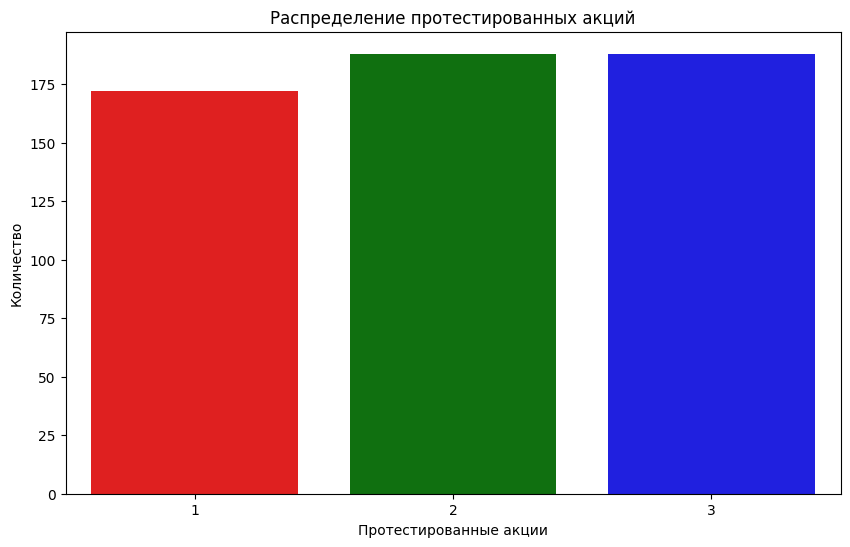

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Promotion', hue='Promotion', palette=['r', 'g', 'b'], legend=False)
plt.title('Распределение протестированных акций')
plt.xlabel('Протестированные акции')
plt.ylabel('Количество');

In [15]:
df.groupby('Promotion', as_index=False).agg({'SalesInThousands' : 'sum'})

,Promotion,SalesInThousands
0,1,9993.03
1,2,8897.93
2,3,10408.52


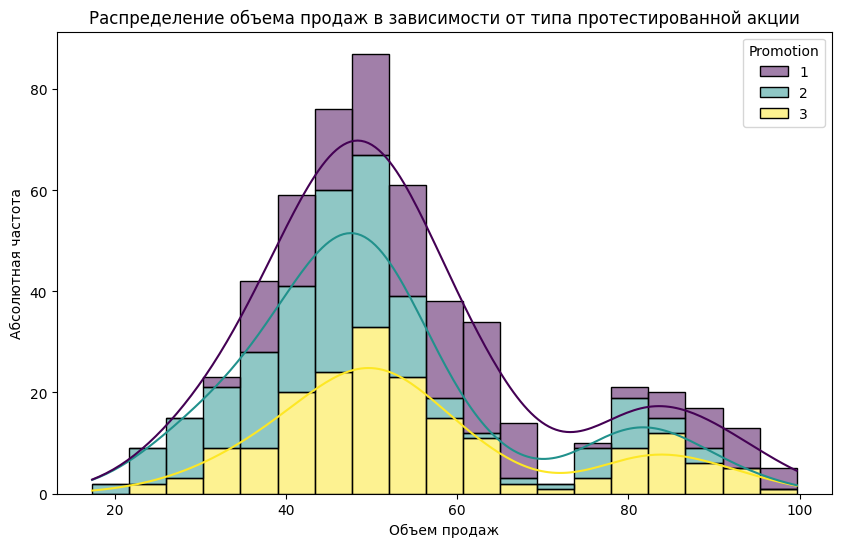

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='SalesInThousands', hue='Promotion', multiple='stack', kde=True, palette='viridis')
plt.title('Распределение объема продаж в зависимости от типа протестированной акции', fontsize=12)
plt.xlabel('Объем продаж', fontsize=10)
plt.ylabel('Абсолютная частота', fontsize=10)
plt.show();

Исходя из графика выше, можно заключить, что третий тип акций принес наибольшие продажи.

In [17]:
df.groupby('MarketSize', as_index=False).agg({'SalesInThousands' : 'sum'})

,MarketSize,SalesInThousands
0,Large,11779.61
1,Medium,14075.31
2,Small,3444.56


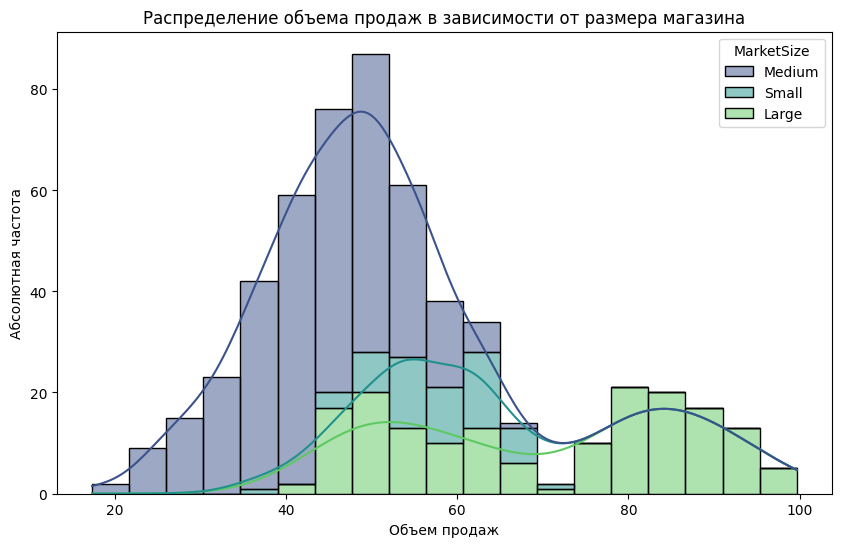

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='SalesInThousands', hue='MarketSize', multiple='stack', kde=True, palette='viridis')
plt.title('Распределение объема продаж в зависимости от размера магазина', fontsize=12)
plt.xlabel('Объем продаж', fontsize=10)
plt.ylabel('Абсолютная частота', fontsize=10)
plt.show();

In [19]:
df.groupby(['MarketSize', 'Promotion'], as_index=False).agg({'SalesInThousands' : 'sum'})

,MarketSize,Promotion,SalesInThousands
0,Large,1,4213.21
1,Large,2,3860.61
2,Large,3,3705.79
3,Medium,1,4576.57
4,Medium,2,4224.35
5,Medium,3,5274.39
6,Small,1,1203.25
7,Small,2,812.97
8,Small,3,1428.34


Магазины среднего размера принесли самые высокие показатели продаж.

In [20]:
df.groupby(['week', 'Promotion'], as_index=False).agg({'SalesInThousands' : 'sum'})

,week,Promotion,SalesInThousands
0,1,1,2504.51
1,1,2,2243.32
2,1,3,2621.48
3,2,1,2447.97
4,2,2,2236.38
5,2,3,2629.61
6,3,1,2527.32
7,3,2,2242.94
8,3,3,2555.76
9,4,1,2513.23


Судя по представленным значениям, объем продаж по неделям не изменяется резко, остается в схожих диапазонах (от ~2175 до ~2629). 

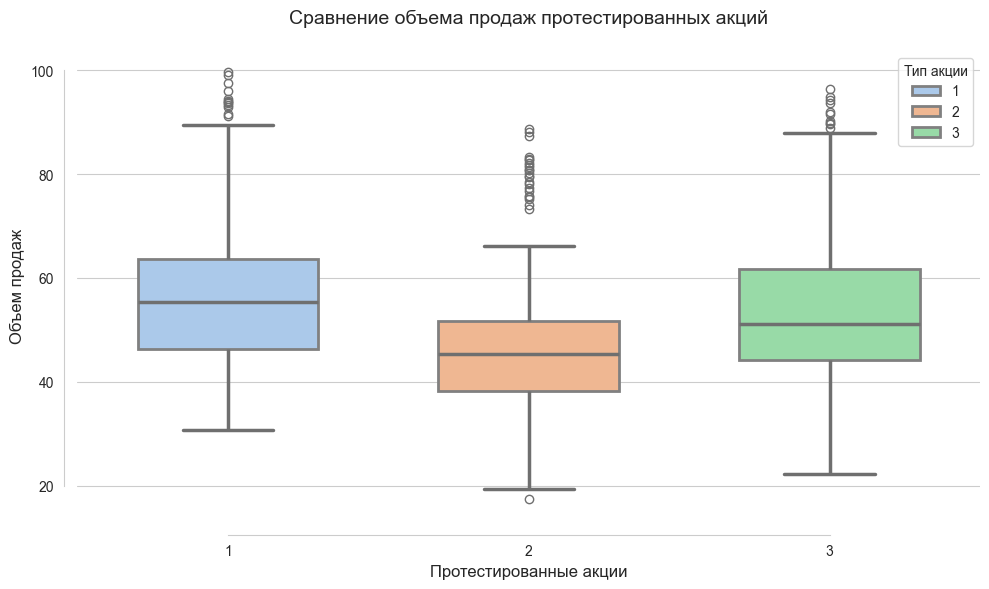

In [21]:
# построим "ящик с усами" 
plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")

ax = sns.boxplot(data=df, x="Promotion", y="SalesInThousands", hue="Promotion",
                palette="pastel", linewidth=2.5, width=0.6,
                boxprops=dict(edgecolor="gray", linewidth=2))

# настройки внешнего вида
plt.title('Сравнение объема продаж протестированных акций', fontsize=14, pad=20)
plt.xlabel('Протестированные акции', fontsize=12)
plt.ylabel('Объем продаж', fontsize=12)
plt.legend(title="Тип акции", frameon=True)

# улучшаем отображение
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()

В соответствии с графиком выше, можно заметить, что в данных присутствуют выбросы. Необходимо избавиться от них для корректного проведения дальнейшего анализа.

##### Работа с выбросами

Заменим значения выбросов на верхнюю и нижнюю границы в соответствии с межквартильным размахом.

In [22]:
def outliers_in_df(df, var_num):
    """
        Функция вычисляет верхнюю и нижнюю границы выбросов 
        для переменной var_num.
    """
    q1 = df[var_num].quantile(0.25)
    q3 = df[var_num].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5*iqr
    low_limit = q1 - 1.5*iqr
    
    return upper_limit, low_limit


def replace_outliers(df, var_num):
    """
        Функция заменяет значения выбросов в df[var] на границы 
        межквартильного размаха.
    """
    upper_limit, low_limit = outliers_in_df(df, var_num)
    df.loc[(df[var_num] < low_limit), var_num] = low_limit
    df.loc[(df[var_num] > upper_limit), var_num] = upper_limit

In [23]:
# список датафреймов по разному типу проводимой акции
df_1_prom = df.loc[df['Promotion']==1]
df_2_prom = df.loc[df['Promotion']==2]
df_3_prom = df.loc[df['Promotion']==3]
all_df_list = [df_1_prom, df_2_prom, df_3_prom]

# замена выбросов для каждого df
for i in all_df_list:
    replace_outliers(i, 'SalesInThousands')

In [24]:
# объединим датафреймы
df_new = pd.concat([df_1_prom, df_2_prom, df_3_prom], ignore_index=True)

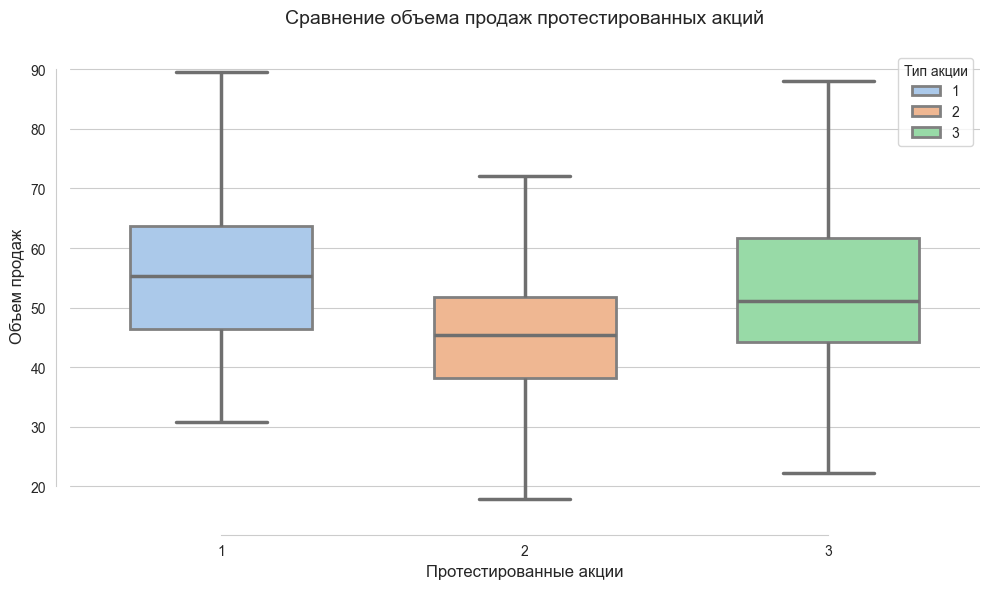

In [25]:
# построим "ящик с усами" 
plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")

ax = sns.boxplot(data=df_new, x="Promotion", y="SalesInThousands", hue="Promotion",
                palette="pastel", linewidth=2.5, width=0.6,
                boxprops=dict(edgecolor="gray", linewidth=2))

# настройки внешнего вида
plt.title('Сравнение объема продаж протестированных акций', fontsize=14, pad=20)
plt.xlabel('Протестированные акции', fontsize=12)
plt.ylabel('Объем продаж', fontsize=12)
plt.legend(title="Тип акции", frameon=True)

# улучшаем отображение
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()

Выбросов больше нет, можем приступать к A/B-тестированию.

In [26]:
df_new.groupby(['Promotion'], as_index=False).agg({'SalesInThousands' : 'sum'})

,Promotion,SalesInThousands
0,1,9929.41
1,2,8712.88
2,3,10367.39


После удаления выбросов ситуация не изменилась: наибольшие объмы продаж у 3 типа протестированной акции.

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
 <b>3. Дисперсионный анализ (ANOVA)<b>
</div>

Проверка дисперсий внутри групп - являются ли они одинаковыми (гомогенными). 

Тест Левена 
1. H0: Дисперсии в выборках не имеют значимых различий.
2. H1: Дисперсии в выборках имеют значимые различия.

In [27]:
# Тест Левена - scipy
levene(df_1_prom['SalesInThousands'], df_2_prom['SalesInThousands'], df_3_prom['SalesInThousands'])

LeveneResult(statistic=np.float64(3.2184808084396104), pvalue=np.float64(0.040777594092796646))

In [28]:
# Тест Левена - pingouin
pg.homoscedasticity(df_new, dv='SalesInThousands', group='Promotion')

,W,pval,equal_var
levene,3.218481,0.040778,False


p-value < 0.05, отклоняем нулевую гипотезу.

Проверка на нормальность распределения внутри групп.

Тест Шапиро-Уилка
1. H0: выборка распределена по нормальному закону
2. H1: закон распределения не является нормальным

In [29]:
print(f"Результаты теста для 1 типа акций: {shapiro(df_1_prom['SalesInThousands'])}")
print(f"Результаты теста для 2 типа акций: {shapiro(df_2_prom['SalesInThousands'])}")
print(f"Результаты теста для 3 типа акций: {shapiro(df_3_prom['SalesInThousands'])}")

Результаты теста для 1 типа акций: ShapiroResult(statistic=np.float64(0.9138930831352003), pvalue=np.float64(1.5967612705651875e-08))
Результаты теста для 2 типа акций: ShapiroResult(statistic=np.float64(0.9449333645106409), pvalue=np.float64(1.2569483890935498e-06))
Результаты теста для 3 типа акций: ShapiroResult(statistic=np.float64(0.9161294460133851), pvalue=np.float64(7.056882084000772e-09))


Все представленные выборки не подчиняются закону нормального распределения.

Исходя из вышепроведенных тестов, необходимо использовать непараметрический ANOVA тест (Критерий Краскела-Уоллиса).
1. H0: все группы имеют одинаковые распределения (медианы)
2. H1: хотя бы одна пара групп имеет отличные распределения (медианы)

In [30]:
kruskal(df_1_prom['SalesInThousands'], df_2_prom['SalesInThousands'], df_3_prom['SalesInThousands'])

KruskalResult(statistic=np.float64(55.46625555799193), pvalue=np.float64(9.029332369036347e-13))

p-value < 0.05, отвергаем нулевую гипотезу и принимаем альтернативную. Существуют статистически значимые различия между типами рекламных акций.

Проведем тест Геймса-Хоуэлла
1. H0: средние значения во всех группах равны
2. H1: средние значения в группе отличаются

In [31]:
pg.pairwise_gameshowell(data=df_new, dv="SalesInThousands", between="Promotion")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,1,2,57.729128,46.345106,11.384022,1.528117,7.449706,331.938426,2.495226e-12,0.791166
1,1,3,57.729128,55.145691,2.583436,1.689463,1.529146,356.908113,2.784815e-01,0.160764
2,2,3,46.345106,55.145691,-8.800585,1.518220,-5.796647,355.944078,4.471047e-08,-0.596679


Статистически значимые различия есть между группами:
*  1 и 2 типом протестированных акций;
*  2 и 3 типом протестированных акций.

Средние значения объема продаж для первого типа протестированных акций являются наибольшими. Типы 1 и 3 акций не имеют значимых статистических отличий.

<div style="background-color: #e6f7ff; padding: 15px; border-left: 5px solid #5bc0de;">
 <b>4. Выводы<b>
</div>

* Наибольшие суммарные показатели объемов продаж представлены у первого и третьего типа протестированных акций (3 тип превышает показатели 1 типа на ~4%).
* Наибольшие средние значения объема продаж получены при тестировании первого типа акции. 
* В ходе анализа были обнаружены статистически значимые отличия между 1 и 2 типами протестированных акций, а также между 2 и 3 типами.
* Между 1 и 3 типами протестированных акций статистически значимых отличий не наблюдается. 
* Наибольшие различия проявляются между 1 и 2 типами акций.
 
В результате проведенного исследования, можно заключить, что первый тип протестированной акции является наилучшим.